In [1]:
!nvidia-smi

Thu Jul 21 11:17:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 23%   26C    P8    16W / 250W |  10913MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 23%   

In [2]:
from jarvis.utils.general import gpus
gpus.find_all()

{0: {'alloc': 10913, 'total': 11178, 'percentage': 0.9762927178386116},
 1: {'alloc': 10913, 'total': 11178, 'percentage': 0.9762927178386116},
 2: {'alloc': 0, 'total': 11178, 'percentage': 0.0},
 3: {'alloc': 10913, 'total': 11178, 'percentage': 0.9762927178386116}}

In [3]:
gpus.find_available()

{2: {'alloc': 0, 'total': 11178, 'percentage': 0.0}}

In [4]:
gpus.autoselect()

[ 2022-07-21 11:17:04 ] CUDA_VISIBLE_DEVICES automatically set to: 2           


In [5]:
import numpy as np
from jarvis.train import datasets
from jarvis.utils.display import imshow
from tensorflow.keras import Input
from jarvis.train.client import Client

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
def show_mri(mri):
    for i in range(mri.shape[0]):
        clear_output(wait=True)
        plt.axis(False)
        plt.imshow(mri[i, :, :, 0] if len(mri.shape) == 4 else mri[i, :, :], cmap='gray')
        plt.show()

In [8]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()

In [9]:
# --- Show a sample training set
xs, ys = next(gen_train)
# imshow(xs['t2w'][0][24], radius=1)
ys['lbl'].reshape(4, 1)

array([[1],
       [0],
       [0],
       [0]], dtype=uint8)

In [10]:
flair = xs['fla']
flair.shape

(4, 48, 96, 96, 1)

In [11]:
flair1 = flair[0]

In [12]:
flair1.shape

(48, 96, 96, 1)

In [13]:
np.min(flair1)

-0.7507961731464879

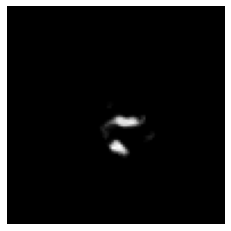

In [14]:
# show_mri(flair1)

In [15]:
ys

{'lbl': array([[[[[1]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]],
 
 
 
        [[[[0]]]]], dtype=uint8)}

In [16]:
ys['lbl'][:, 0, 0, 0]

array([[1],
       [0],
       [0],
       [0]], dtype=uint8)

In [17]:
xs.keys()

dict_keys(['t2w', 't1w', 't1wce', 'fla', 'lbl'])

In [18]:
# --- Print keys 
for key, arr in xs.items():
    print('xs key: {} | shape = {}'.format(key.ljust(8), arr.shape))

xs key: t2w      | shape = (4, 48, 96, 96, 1)
xs key: t1w      | shape = (4, 48, 96, 96, 1)
xs key: t1wce    | shape = (4, 48, 96, 96, 1)
xs key: fla      | shape = (4, 48, 96, 96, 1)
xs key: lbl      | shape = (4, 1, 1, 1, 1)


In [19]:
# --- Create model inputs
inputs = client.get_inputs(Input)

In [20]:
inputs

{'t2w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't2w')>,
 't1w': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1w')>,
 't1wce': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 't1wce')>,
 'fla': <KerasTensor: shape=(None, 48, 96, 96, 1) dtype=float32 (created by layer 'fla')>,
 'lbl': <KerasTensor: shape=(None, 1, 1, 1, 1) dtype=uint8 (created by layer 'lbl')>}

## New Version

In [32]:
from ResNet10.ResNet10_3D import ResNet10_3D
base_model = ResNet10_3D()

In [33]:
bce = tf.keras.losses.BinaryCrossentropy()

In [34]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss=bce, metrics=['acc'])

In [35]:
def prep(data):
    xs, ys = data
    inp = np.empty((4, 48, 96, 96, 4))
    inp = np.stack([xs['t2w'], xs['t1w'], xs['t1wce'], xs['fla']], axis=4)
    inp = inp.reshape((4, 48, 96, 96, 4))
    x_prep = (inp-np.min(inp))/(np.max(inp)-np.min(inp))
    if(np.isnan(x_prep).any()):
        x_prep = np.random.normal(size=(4, 48, 96, 96, 4))
    return (x_prep, ys['lbl'].reshape(4, 1))

In [36]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()
history = base_model.fit(x=map(prep, gen_train), steps_per_epoch=100, epochs=1)

 12/100 [==>...........................] - ETA: 1:07 - loss: 2.0683 - acc: 0.4375

/home/caidm/jarvis/jarvis-core/jarvis/train/client/client.py:983: RuntimeWarning: invalid value encountered in true_divide
  arr_ = arr / scale


100/100 [==============================] - 82s 769ms/step - loss: 0.8913 - acc: 0.5125


In [37]:
base_model.evaluate(x=map(prep, gen_valid), steps=10)

10/10 [==============================] - 8s 808ms/step - loss: 66.7723 - acc: 0.5000


[66.77233123779297, 0.5]

In [38]:
from tqdm import tqdm

In [39]:
NUM_VAL_SCANS = 100

In [40]:
gen_valid_prep = map(prep, gen_valid)
preds = []
labels = []
for i, data in tqdm(enumerate(gen_valid_prep)):
    x, y = data
    pred = base_model.predict(x)
    preds.append(pred)
    labels.append(y.reshape(4, 1))
    if i == NUM_VAL_SCANS:
        break

100it [01:24,  1.19it/s]


In [41]:
preds = np.array(preds).reshape(-1,)
labels = np.array(labels).reshape(-1,)

In [42]:
disc_preds = np.zeros(preds.shape)
disc_preds[preds > 0.5] = 1

In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score

acc = accuracy_score(labels, disc_preds)
auc = roc_auc_score(labels, preds)
print(f'Validated on {NUM_VAL_SCANS} scans...')
print(f'Accuracy: {acc}')
print(f'AUC: {auc}')

Validated on 100 scans...
Accuracy: 0.5198019801980198
AUC: 0.5034486990672559


## Old Version

In [22]:
from ResNet10.ResNet10_3D import build_resnet
base_model = build_resnet()

In [23]:
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='binary_crossentropy', metrics=['acc'])

In [24]:
from tensorflow.keras.losses import BinaryCrossentropy

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
bce = BinaryCrossentropy()
# @tf.function
def train_step(x, y):
#     print(y.shape)
    loss = base_model.train_on_batch(x, y)
#     with tf.GradientTape() as tape:
# #         print('beginning training...')
#         y_hat = base_model(x, training=True)
# #         print(y_hat.shape)
# #         print('done training...')
#         loss = bce(y, y_hat)
#     grads = tape.gradient(loss, base_model.trainable_variables)
#     opt.apply_gradients(zip(grads, base_model.trainable_variables))
    return loss

In [26]:
annoying_case = None
annoying_case_unproc = None

In [27]:
def train(train_dataset, n_epochs=1, max_steps_per_epoch=None):
    global annoying_case, annoying_case_unproc
    for epoch in range(n_epochs):
        for i, batch in enumerate(train_dataset):
            xs, ys = batch
            inp = np.empty((4, 48, 96, 96, 4))
            inp[:, :, :, :, 0] = xs['t2w'][:, :, :, 0]
            inp[:, :, :, :, 1] = xs['t1w'][:, :, :, 0]
            inp[:, :, :, :, 2] = xs['t1wce'][:, :, :, 0]
            inp[:, :, :, :, 3] = xs['fla'][:, :, :, 0]
            inp = tf.image.per_image_standardization(inp)
#             print(xs['fla'].shape)
#             fla = xs['fla']
            x_prep = inp # (inp-np.min(inp))/(np.max(inp)-np.min(inp))
            if max_steps_per_epoch is not None:
                if i == max_steps_per_epoch:
                    break
#             adversarial = (epoch >= 1)
            if(np.isnan(x_prep).any()):
                continue
            l1 = base_model.train_on_batch(x_prep, ys['lbl'].reshape(4, 1))
#             train_step(x_prep, ys['lbl'].reshape(4, 1))#[:, 0, 0, 0])
#             del batch
            clear_output(wait=True)
            if np.isnan(np.max(x_prep)) or np.isnan(np.min(x_prep)):
                annoying_case = x_prep
                annoying_case_unproc = fla
#             show_mri(x_prep[0])
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            print(f'Step {i+1}')
#             print(f'MRI Shape: {x_prep.shape}')
#             print(f'Max Flair: {np.max(x_prep)}')
#             print(f'Min Flair: {np.min(x_prep)}')
            print(f'Loss: {l1}')
            

In [28]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [29]:
# --- prepare generators
client = Client('/data/raw/miccai_rsna/data/ymls/client-3d.yml')
gen_train, gen_valid = client.create_generators()
train(gen_train, max_steps_per_epoch=100, n_epochs=1)

Epoch 1/1
Step 100
Loss: [0.7631871104240417, 0.25]


In [30]:
NUM_VAL_SCANS = 100

In [31]:
preds = []
labels = []
for i, batch in enumerate(gen_train):
    xs, ys = batch
    inp = np.empty((4, 48, 96, 96, 4))
    inp[:, :, :, :, 0] = xs['t2w'][:, :, :, 0]
    inp[:, :, :, :, 1] = xs['t1w'][:, :, :, 0]
    inp[:, :, :, :, 2] = xs['t1wce'][:, :, :, 0]
    inp[:, :, :, :, 3] = xs['fla'][:, :, :, 0]
    inp = tf.image.per_image_standardization(inp)
    pred = base_model.predict(inp)
    y = ys['lbl']
    labels.append(y.reshape(4, 1))
    preds.append(pred)
    if i == NUM_VAL_SCANS:
        break

In [32]:
preds = np.array(preds).reshape(-1,)
labels = np.array(labels).reshape(-1,)

In [33]:
preds

array([4.10523031e-15, 3.63088812e-17, 3.89473364e-02, 2.49713717e-04,
       3.00268695e-20, 3.44173370e-11, 1.50106683e-01, 4.26837393e-15,
       5.15018962e-02, 1.92043602e-01, 1.82592703e-06, 2.41208831e-08,
       8.91208035e-24, 1.77577785e-21, 3.25475866e-12, 2.54497737e-27,
       1.88686100e-22, 2.08515996e-20, 4.04184963e-10, 1.06486969e-01,
       6.40979820e-08, 4.82880331e-18, 1.08820432e-17, 8.77522715e-29,
       6.08884124e-03, 2.18305066e-01, 1.52334134e-04, 1.59904305e-02,
       5.87157682e-02, 1.99861659e-15, 1.49401511e-21, 1.87561383e-24,
       1.99588034e-02, 6.54039752e-07, 5.03366859e-09, 2.17303992e-22,
       5.01552466e-10, 3.12979944e-04, 3.44018162e-13, 1.73571447e-04,
       3.89340261e-15, 1.80589159e-12, 1.65224788e-14, 2.00502690e-08,
       1.62622424e-27, 6.60282901e-20, 1.76737960e-02, 1.01394165e-19,
       2.16681563e-29, 9.02517431e-19, 2.73678684e-11, 5.77406958e-02,
       2.18696311e-20, 7.96230512e-11, 1.66125474e-07, 4.32295674e-15,
      

In [34]:
disc_preds = np.zeros(preds.shape)
disc_preds[preds > 0.5] = 1

In [35]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [36]:
acc = accuracy_score(labels, disc_preds)
auc = roc_auc_score(labels, preds)
print(f'Validated on {NUM_VAL_SCANS} scans...')
print(f'Accuracy: {acc}')
print(f'AUC: {auc}')

Validated on 100 scans...
Accuracy: 0.47277227722772275
AUC: 0.5390703733746283
